# Potato Disease Classification

In [2]:
#Import all the Dependencies

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [35]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
32 * 68

2176

In [12]:
for image_batch, labels_batch in dataset.take(1): # take(1) gives you one batch
    print(image_batch.shape)
    print(labels_batch.numpy()) #every element is a tensor so you need to convert to numpy


(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'] [0,1,2 ]

In [14]:
for image_batch, labels_batch in dataset.take(1): # take(1) gives you one batch
    print(image_batch[0].shape)
    print(class_names[labels_batch[0].numpy()])

(256, 256, 3)
Potato___Early_blight


In [15]:
for image_batch, labels_batch in dataset.take(1): # take(1) one batch
    print(image_batch[0]) #first image
#     print("*******************") # every image is a 3D-Array
#     print(image_batch[0].numpy()) # every image is a 3D-Array

tf.Tensor(
[[[110. 106. 120.]
  [133. 129. 143.]
  [126. 122. 136.]
  ...
  [187. 189. 202.]
  [191. 193. 206.]
  [195. 197. 210.]]

 [[125. 121. 135.]
  [120. 116. 130.]
  [111. 107. 121.]
  ...
  [188. 190. 203.]
  [193. 195. 208.]
  [196. 198. 211.]]

 [[104. 100. 114.]
  [100.  96. 110.]
  [108. 104. 118.]
  ...
  [188. 190. 203.]
  [189. 191. 204.]
  [191. 193. 206.]]

 ...

 [[108. 104. 119.]
  [121. 117. 132.]
  [122. 118. 133.]
  ...
  [191. 193. 205.]
  [181. 183. 195.]
  [186. 188. 200.]]

 [[111. 107. 122.]
  [123. 119. 134.]
  [122. 118. 133.]
  ...
  [173. 175. 187.]
  [195. 197. 209.]
  [187. 189. 201.]]

 [[125. 121. 136.]
  [136. 132. 147.]
  [132. 128. 143.]
  ...
  [200. 202. 214.]
  [192. 194. 206.]
  [179. 181. 193.]]], shape=(256, 256, 3), dtype=float32)


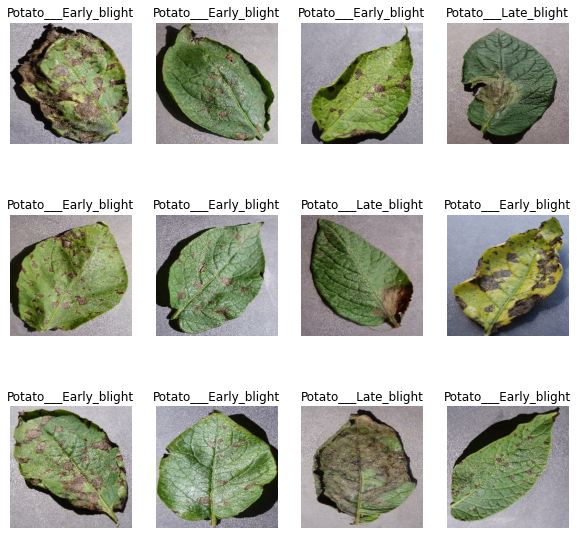

In [17]:
#Let's display couple of images. Out of 32 i want to display 12 images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # converting to integer
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

80% ==> training

20% ==> 10% validation, 10% test

In [19]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [20]:
train_ds = dataset.take(54)
len(train_ds)

54

In [21]:
test_ds = dataset.skip(54) # eqivalent in pandas [54:]
len(test_ds)

14

In [22]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [23]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [24]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [25]:
# function goal is to take tensorflow dataset and also take the train_split ratio, 

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf(dataset)

In [27]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


# 2. Preprosessing

### 2.1 Cache, Shuffle, and Prefetch the Dataset


In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [30]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 29s 241ms/step - loss: 0.9239 - accuracy: 0.4786 - val_loss: 0.9054 - val_accuracy: 0.3854
Epoch 2/10
54/54 [==============================] - 12s 223ms/step - loss: 0.7643 - accuracy: 0.6233 - val_loss: 0.6327 - val_accuracy: 0.6875
Epoch 3/10
54/54 [==============================] - 12s 227ms/step - loss: 0.5560 - accuracy: 0.7564 - val_loss: 0.4992 - val_accuracy: 0.7500
Epoch 4/10
54/54 [==============================] - 12s 231ms/step - loss: 0.4203 - accuracy: 0.8102 - val_loss: 0.3011 - val_accuracy: 0.8958
Epoch 5/10
54/54 [==============================] - 12s 231ms/step - loss: 0.2759 - accuracy: 0.8877 - val_loss: 0.2656 - val_accuracy: 0.9010
Epoch 6/10
54/54 [==============================] - 12s 231ms/step - loss: 0.1944 - accuracy: 0.9271 - val_loss: 0.2251 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 12s 231ms/step - loss: 0.2536 - accuracy: 0.9005 - val_loss: 0.2170 - val_accuracy: 0.9062

In [37]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 76ms/step - loss: 0.2810 - accuracy: 0.9102


In [38]:
scores

[0.28099530935287476, 0.91015625]

In [39]:
# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

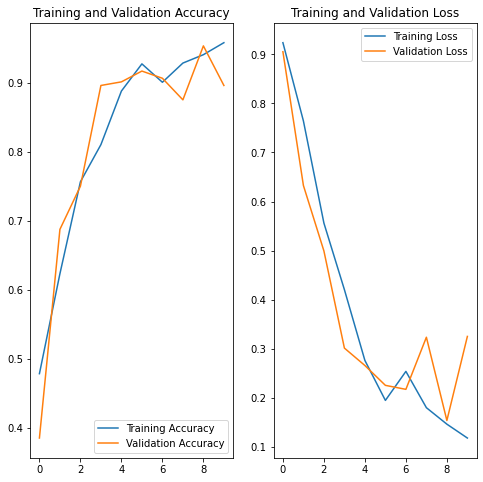

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
Actual Label: Potato___Early_blight
1/1 [==============================] - 0s 146ms/step
batch_prediction:  [1.0000000e+00 4.2489896e-09 7.1275504e-20]
Predicted Label: Potato___Early_blight


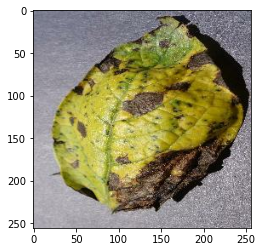

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):  # 32 images
    
    first_image = images_batch[0].numpy().astype('uint8') # take the first image
    first_label = labels_batch[0].numpy() # return the label of the image [ 0 or 1 or 2]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch) # this will be the prediction for 32 images 
    
    print("batch_prediction: ",batch_prediction[0])
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])] 
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


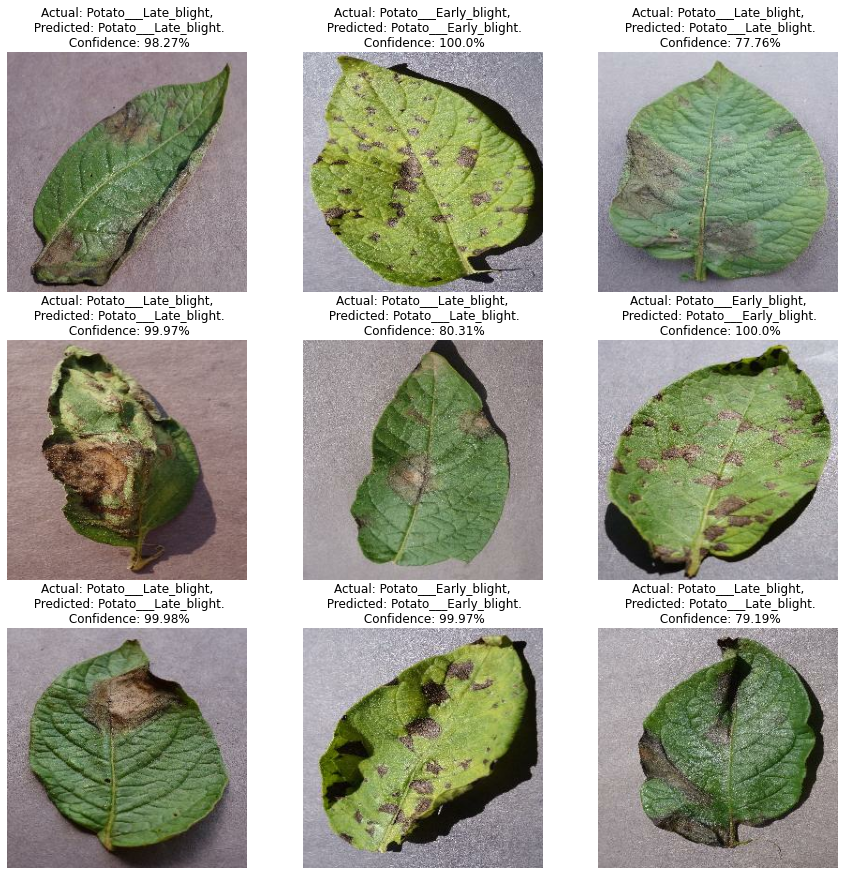

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9): #pick only 9 images 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [46]:
model_version=1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [48]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets
